In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
datetime.datetime.strptime
from pandas import to_datetime
from collections import defaultdict
from scipy.stats.stats import pearsonr


In [2]:
# Legge il CSV
df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0)
# Trasforma il campo "Sale" in un float
df["Sale"] = df["Sale"].str.replace(",", ".").astype(float)
# Trasforma il campo "BasketDate" in un datetime
df["BasketDate"] = pd.to_datetime(df["BasketDate"])

df.head()

BasketID          BasketDate  Sale  CustomerID CustomerCountry  ProdID  \
0   536365 2010-01-12 08:26:00  2.55     17850.0  United Kingdom  85123A   
1   536365 2010-01-12 08:26:00  3.39     17850.0  United Kingdom   71053   
2   536365 2010-01-12 08:26:00  2.75     17850.0  United Kingdom  84406B   
3   536365 2010-01-12 08:26:00  3.39     17850.0  United Kingdom  84029G   
4   536365 2010-01-12 08:26:00  3.39     17850.0  United Kingdom  84029E   

                             ProdDescr  Qta  
0   WHITE HANGING HEART T-LIGHT HOLDER    6  
1                  WHITE METAL LANTERN    6  
2       CREAM CUPID HEARTS COAT HANGER    8  
3  KNITTED UNION FLAG HOT WATER BOTTLE    6  
4       RED WOOLLY HOTTIE WHITE HEART.    6

# DATA SEMANTICS



In [ ]:
df.info()

Nel dataset si descrivono le sessioni di acquisto di un certo numero di clienti. Una sessione di acquisto, detta basket (`BasketID`) e si svolge in una data (`BasketDate`), e viene effettuata da un cliente (CustomerID) residente in uno stato (`CustomerCountry`).
Ogni sessione rappresenta una serie di prodotti acquistati da un cliente, e in un record è possibile ritrovare, per il singolo prodotto, l’identificativo (`ProdID`), la descrizione (`ProdDescr`), e  la quantità (`Qtà`). Infine viene riportato il costo unitario del prodotto (`Sale`).

# DISTRIBUTION OF VARIABLES AND STATISTICS


In [ ]:
df.describe()

In [ ]:
print("Distinct Values in BasketID: \n", df.BasketID.nunique())
print("Distinct Values in BasketDate:\n", df.BasketDate.nunique())
print("Distinct Values in Sale: \n", df.Sale.nunique())
print("Distinct Values in CustomerID: \n", df.CustomerID.nunique())
print("Distinct Values in CustomerCountry: \n", df.CustomerCountry.nunique())
print("Distinct Values in ProdID: \n", df.ProdID.nunique())
print("Distinct Values in ProdDescr: \n", df.ProdDescr.nunique())

## Date e ore di maggiore traffico nei negozi

## Orari di maggiore frequentazione

Di seguito si mostrano i diagrammi a barre contenenti il numero di `BasketID` per ora del giorno.

In [ ]:
df.groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

L'ora del giorno più frequentata sembra essere le 12.

Si restringono le date al 2010 e si osserva come in questo anno l'ora più frequentata siano le 14

In [ ]:
df[df["BasketDate"].dt.year == 2010].groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

Mentre nel 2011 l'orario di maggiore frequenza si confermano le 12.

In [ ]:
df[df["BasketDate"].dt.year == 2011].groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

## Date di maggiore frequentazione

Si mostrano le date di maggiore traffico per gli anni 2010 e 2011

Dato che relativamente al 2010 sono presenti solo 20 record è possibile mostrarli in un unico grafico

In [ ]:
df_2010 = df[df["BasketDate"].dt.year == 2010]

print(df_2010["BasketDate"].dt.date.nunique())

df_2010.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")

TODO: Grafici per ogni gruppo di mesi del 2011

In [ ]:
first_three_months = df[(df["BasketDate"].dt.year == 2011) & (df["BasketDate"].dt.month < 3 )]

first_three_months.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")

## Paesi in cui sono stati effettuati piu acquisti

In [ ]:
df.groupby('CustomerCountry')["BasketID"].nunique().plot(kind='bar',

title='Best buy coutry')

In [ ]:
#verificare a cosa è dovuta la variazione di prezzo
df.groupby(["ProdID",'Qta'])["Sale"].unique()

# ASSESSING DATA QUALITY (MISSING VALUES, OUTLIERS)

In [ ]:
df.info()

Si osserva che le uniche quantità settate a NaN sono `CustomerID` e le `ProdDescr`. I record che non hanno `CustomerID` non portano informazioni riguardo al profilo del cliente, mentre la `ProdDescr` può essere recuperata dai record con lo stesso `ProdID`.

In [ ]:
x = df[(df["ProdDescr"].fillna("").str.islower())]
display(x)
display("Number of BasketIDs", x["BasketID"].nunique())

Tutti i record che hanno `ProdDescr` scritta tutta in minuscolo hanno `CustomerID` a NaN e il loro carrello (`BasketID`) contiene un solo elemento. Si può quindi supporre che non si riferiscano ad una vera e propria transazione con un cliente, e si sceglie di eliminarli dal dataset.

In [ ]:
df = df[~(df["ProdDescr"].fillna("").str.islower())]

## Outliers nella quantità (`Qta`)

La distribuzione della quantità segue la seguente distribuzione:

In [ ]:
boxplot = df.boxplot(column=['Qta'])

Analizziamo meglio i record che si mostrano esterni al box plot:

In [ ]:
df[(df["Qta"] < -60000) | (df["Qta"] > 60000)]

Questi 4 record hanno le stesse caratteristiche e si eliminano a vicenda, per cui non portano informazione e possono essere eliminati.

In [ ]:
df = df[(df["Qta"] > -60000) & (df["Qta"] < 60000)]

In [ ]:
df[(df["Qta"] > -5000) & (df["Qta"] < 5000)].boxplot(column="Qta")

In [ ]:
df[(df["Qta"] < 0)]
#9752 record

In [ ]:
df[(df["Qta"] < 0) & (df["BasketID"].str.startswith("C"))]
#9084 di 9752 hanno BasketId che inizia con C, tutti con CustomerID 
#diverso da Nan ==> vengono mantenuti 

In [ ]:
df[(df["Qta"] < 0) & (df["BasketID"].str.startswith("C")) & (df['CustomerID'].isnull())]
#179 record con CustomerId=Nan ==> rimossi

In [ ]:
df[(df["Qta"] < 0) & (df["BasketID"].str.startswith("C")) & ~(df['CustomerID'].isnull())]
#infatti abbiamo 8905 record con CustomerID != Nan
#8905+179=9084

In [ ]:
df[df["Sale"] > 30000] #manual di valore massimo 
df[(df["ProdDescr"] == 'Manual')]
#se esiste un solo ProdId che ha tale Sale, possiamo fixarlo, altrimenti rimuoviamo/decidere
#potrebbe essere roba inserita a mano

Boxplot raggruppato per paese

In [ ]:
df.boxplot(column=["CustomerID"], by="CustomerCountry")

# Outliers in Sale

In [ ]:
df["Sale"].plot.box()

In [ ]:
df[(df["Sale"] < 0)]
#vengono rimossi

In [ ]:
df=df[(df["Sale"] >= 0)]

In [ ]:
df[df["Sale"] > 30000]
#viene mantenuto in quanto ha informazioni

# VARIABLES TRANSFORMATION & GENERATION

## Prezzo nullo

I record con prezzo 0 si considerano missing values, per cui si cerca di recuperare il valore di `Sale` a partire dalla media dei prezzi dello stesso `ProdID`.

In [ ]:
df["Sale"] = df.groupby("ProdID")["Sale"].transform(lambda group: group.replace(to_replace=0, method="ffill", value = group.mean()))

## ProdDescr non disponibile

Per rendere più interpretabili certe analisi riteniamo che sia utile recuperare la `ProdDescr` degli elementi che non l'hanno settata. Analogamente al caso precedente, si costruisce una funzione che recupera la descrizione di ogni prodotto dagli altri record.

In [ ]:
def replace_first_notna(group: pd.Series, column: str):
    # Indice del primo record con ProdID comune non NaN
    i: int = group.first_valid_index()
    # Se i è None non ci sono ProdDescr valide
    if i is None:
        return group
    # Valore di ProdDescr valido
    value = df.loc[i][column]
    return group.fillna(value)
 
df["ProdDescr"] = df.groupby("ProdID")["ProdDescr"].transform(lambda x: replace_first_notna(x, "ProdDescr"))

In [ ]:
df[df["ProdDescr"].isnull()]

# PAIRWISE CORRELATION & ELIMINATION OF REDUNTANT VARIABLES

Si discretizzano le variabili non numeriche all'interno del dataset:

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_copy = df.copy()
for column in {"BasketID", "BasketDate", "CustomerCountry", "ProdID", "ProdDescr"}:
    df_copy[column] = le.fit_transform(df_copy[column].astype(str))

Si definisce la matrice di correlazione tra gli attributi:

In [ ]:
df_copy.corr().abs().style.background_gradient(cmap='coolwarm')

Dato che non si osservano correlazioni notevoli (maggiori dell'80%) non è il caso di eliminare attributi ridondanti.

In [ ]:
df.to_csv("./preprocessed.csv")

# DATA PREPARATION

Costruzione di attributi che caratterizzano il comportamento di un utente.

Si caricano i dati preprocessati, considerando per ora solo quelli con `CustomerID` non nullo:

In [3]:
df = pd.read_csv("./preprocessed.csv", index_col=0)
df = df[~(df["CustomerID"].isnull())]
df["BasketDate"] = pd.to_datetime(df["BasketDate"])
df

BasketID          BasketDate   Sale  CustomerID CustomerCountry  \
0        536365 2010-01-12 08:26:00   2.55     17850.0  United Kingdom   
1        536365 2010-01-12 08:26:00   3.39     17850.0  United Kingdom   
2        536365 2010-01-12 08:26:00   2.75     17850.0  United Kingdom   
3        536365 2010-01-12 08:26:00   3.39     17850.0  United Kingdom   
4        536365 2010-01-12 08:26:00   3.39     17850.0  United Kingdom   
...         ...                 ...    ...         ...             ...   
541905   581587 2011-09-12 12:50:00   2.10     12680.0          France   
541906   581587 2011-09-12 12:50:00   4.15     12680.0          France   
541907   581587 2011-09-12 12:50:00   4.15     12680.0          France   
541908   581587 2011-09-12 12:50:00   4.95     12680.0          France   
541909   581587 2011-09-12 12:50:00  18.00     12680.0          France   

        ProdID                            ProdDescr  Qta  
0       85123A   WHITE HANGING HEART T-LIGHT HOLDER    6  
1        71053                  WHITE METAL LANTERN    6  
2       84406B       CREAM CUPID HEARTS COAT HANGER    8  
3       84029G  KNITTED UNION FLAG HOT WATER BOTTLE    6  
4       84029E       RED WOOLLY HOTTIE WHITE HEART.    6  
...        ...                                  ...  ...  
541905   22899         CHILDREN'S APRON DOLLY GIRL     6  
541906   23254        CHILDRENS CUTLERY DOLLY GIRL     4  
541907   23255      CHILDRENS CUTLERY CIRCUS PARADE    4  
541908   22138        BAKING SET 9 PIECE RETROSPOT     3  
541909    POST                              POSTAGE    1  

[406826 rows x 8 columns]

In [4]:
from indicators import customer_features

customer_indicators = df.groupby("CustomerID").apply(customer_features)
customer_indicators = pd.DataFrame(customer_indicators.values.tolist(), index=customer_indicators.index)
customer_indicators

I   Iu  spending  Imax  returned_items    best_country  \
CustomerID                                                              
12347.0     2458  103   4310.00   676               0         Iceland   
12348.0     2341   22   1797.24  1254               0         Finland   
12349.0      631   73   1757.55   631               0           Italy   
12350.0      197   17    334.40   197               0          Norway   
12352.0      470   59   2506.04   127              66          Norway   
...          ...  ...       ...   ...             ...             ...   
18280.0       45   10    180.60    45               0  United Kingdom   
18281.0       54    7     80.82    54               0  United Kingdom   
18282.0       98   12    178.05    75               5  United Kingdom   
18283.0     1397  263   2094.88   251               0  United Kingdom   
18287.0     1586   59   1837.28   990               0  United Kingdom   

            returning  max_cost  min_cost  most_bought_cost  \
CustomerID                                                    
12347.0          0.00     12.75       NaN              3.75   
12348.0          0.00     40.00       NaN              0.29   
12349.0          0.00    300.00       NaN              1.65   
12350.0          0.00     40.00       NaN              1.25   
12352.0        960.63    376.50    376.50              4.95   
...               ...       ...       ...               ...   
18280.0          0.00      9.95       NaN              2.95   
18281.0          0.00     16.95       NaN              0.42   
18282.0          1.45     12.75      0.29             12.75   
18283.0          0.00     15.95       NaN              1.65   
18287.0          0.00      8.50       NaN              1.25   

            most_returned_cost  avg_bought  avg_returned  hour  month  \
CustomerID                                                              
12347.0                   0.00    2.644011           NaN    14      7   
12348.0                   0.00    5.764839           NaN    19     12   
12349.0                   0.00    8.289041           NaN     9     11   
12350.0                   0.00    3.841176           NaN    16      2   
12352.0                   2.95   15.930706        85.699    14      3   
...                        ...         ...           ...   ...    ...   
18280.0                   0.00    4.765000           NaN     9      7   
18281.0                   0.00    5.622857           NaN    10     12   
18282.0                   0.29    5.199167         0.290    13      5   
18283.0                   0.00    1.614987           NaN    14      6   
18287.0                   0.00    1.493571           NaN    10     12   

            baskets         E  
CustomerID                     
12347.0           7  6.015601  
12348.0           4  4.233442  
12349.0           1  5.802215  
12350.0           1  3.977269  
12352.0          11  5.567352  
...             ...       ...  
18280.0           1  3.207542  
18281.0           1  2.462523  
18282.0           3  2.660805  
18283.0          16  7.281375  
18287.0           3  5.450173  

[4371 rows x 17 columns]

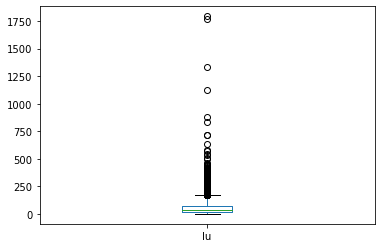

In [183]:
customer_indicators["Iu"].plot.box()

In [ ]:
customer_indicators["I"].plot.box()

In [184]:
customer_indicators=customer_indicators[customer_indicators["I"]<100000]
customer_indicators=customer_indicators[customer_indicators["Iu"]<1500]

Preprocessing Dati per clustering

In [185]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics

le = LabelEncoder()

#prendo una copia di customer_indicators 
CICopy = customer_indicators.copy()

#CODIFICO COUNTRY
CICopy['best_country'] = le.fit_transform(CICopy['best_country'])
#FILL NAN
CICopy=CICopy.fillna(0)
#rimuovo outliers scomodi al clustering
CICopy=CICopy[CICopy["spending"]<150000]

CICopy.corr().style.background_gradient(cmap='coolwarm')

Scelgo un sottoinsieme di 5 attributi, riducendo cosi la dimensione dello spazio.
Non vengono presi coppie di attributi con correlazione > 0.8 

In [186]:
#prendo sottoinsieme del dataset
CICopyClustering=CICopy.iloc[:][["I","Iu","Imax","most_bought_cost","avg_bought","E"]]

# applico MinMaxScaler, in quanto non avendo una distribuzione normale dei dati
# usando la normalizzazione standard si perde la distribuzione originale dei dati
scaler = MinMaxScaler()

X=scaler.fit_transform(CICopyClustering) 





In [187]:
CICopyClustering.corr().style.background_gradient(cmap='coolwarm')

# Subtask 1: identificazione del valore K

K: 5
SSE 31.85842181693675
Silhouette 0.4647775699721188
Separation 0.6934655319919331 

K: 10
SSE 14.406071686602298
Silhouette 0.4527132086897605
Separation 0.6603015567409352 

K: 15
SSE 9.201713031562175
Silhouette 0.4263200067637204
Separation 0.7302015318660434 

K: 20
SSE 7.2180226333759485
Silhouette 0.38791071810819644
Separation 0.7791980800642558 



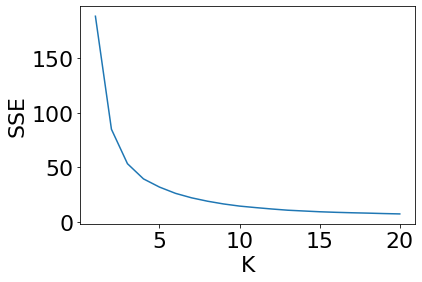

[188.8178560330432, 84.99794240581055, 53.35853324946284, 39.399197203229754, 31.85842181693675, 26.111939400338247, 22.01062680269289, 18.889138748428888, 16.369072099363127, 14.406071686602298, 13.023572147801673, 11.748661566785387, 10.631380096514755, 9.905630623120492, 9.201713031562175, 8.686708607287407, 8.279194877492952, 7.943566645539017, 7.542012889187977, 7.2180226333759485]


In [188]:
sse_list = list()
max_k = 20
start_k=1
for k in range(start_k, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=30, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)
    
    if((k%5==0)):
        print("K: "+str(k))
        print('SSE %s' % kmeans.inertia_)
        print('Silhouette %s' % metrics.silhouette_score(X, kmeans.labels_))
        print('Separation %s \n' % metrics.davies_bouldin_score(X, kmeans.labels_))
        

plt.plot(range(start_k, max_k + 1), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()


print(sse_list)

guardando la curva dell'SSE al variare di K, e che i valori delle metriche SSE, Silhouette e Separation tendono ad avere un Delta sempre piu piccolo dopo K=5, si sceglie k=4

In [189]:
kmeans = KMeans(n_clusters=3, n_init=30, max_iter=100)
kmeans.fit(X)
    

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % metrics.silhouette_score(X, kmeans.labels_))
print('Separation %s \n' % metrics.davies_bouldin_score(X, kmeans.labels_))

SSE 53.3531197814915
Silhouette 0.48323749005163646
Separation 0.664861832959314 



# Subtask 2: descrizione dei cluster ottenuti

In [190]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
#"I","Iu","Imax","most_bought_cost","avg_bought","E"]]

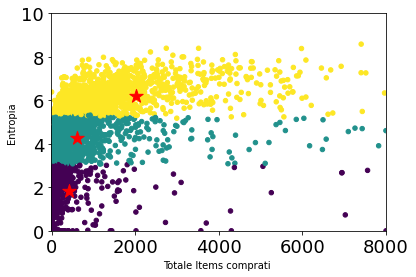

In [191]:
plt.scatter(CICopyClustering['I'], CICopyClustering['E'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:,5], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-10, 8000)
plt.ylim(-0,10)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

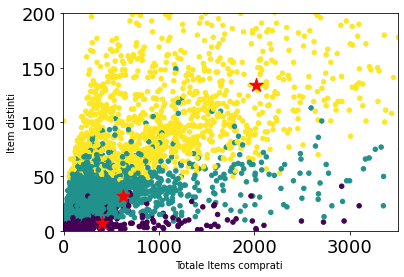

In [192]:
plt.scatter(CICopyClustering['I'], CICopyClustering['Iu'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:, 1], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-10, 3500)
plt.ylim(-0,200)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Item distinti')
plt.show()

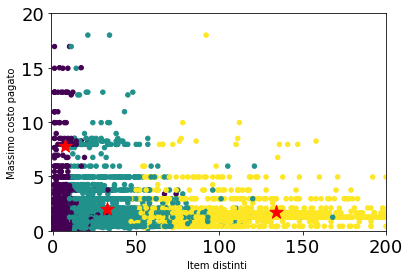

In [193]:
#:][["I","Iu","most_bought_cost","max_cost","E"]]
#"I","Iu",Imax,most_bought_cost","max_cost","E"]
plt.scatter(CICopyClustering['Iu'], CICopyClustering['most_bought_cost'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 1], centers[:, 3], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-1, 200)
plt.ylim(-0,20)
plt.xlabel('Item distinti ')
plt.ylabel('Massimo costo pagato')
plt.show()

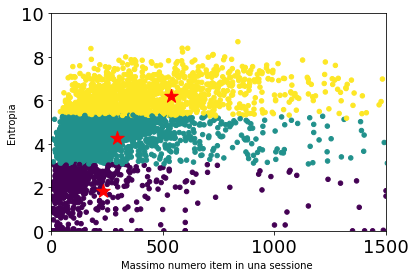

In [194]:
plt.scatter(CICopyClustering['Imax'], CICopyClustering['E'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 2], centers[:, 5], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-1, 1500)
plt.ylim(-0,10)
plt.xlabel('Massimo numero item in una sessione ')
plt.ylabel('Entropia')
plt.show()

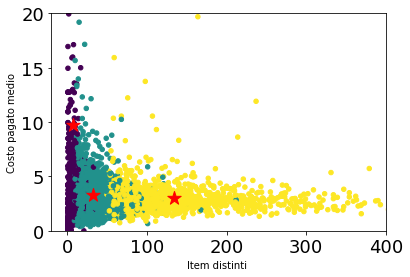

In [195]:
plt.scatter(CICopyClustering['Iu'], CICopyClustering['avg_bought'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 1], centers[:, 4], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-20, 400)
plt.ylim(-0,20)
plt.xlabel('Item distinti ')
plt.ylabel('Costo pagato medio')
plt.show()

In [200]:
kmeans.cluster_centers_

array([[0.00914971, 0.00477524, 0.03117675, 0.00383417, 0.00478881,
        0.20612467],
       [0.0118724 , 0.02361919, 0.03523024, 0.00099944, 0.00162345,
        0.47874865],
       [0.02985302, 0.10006801, 0.05097779, 0.00083157, 0.00149609,
        0.69663951]])

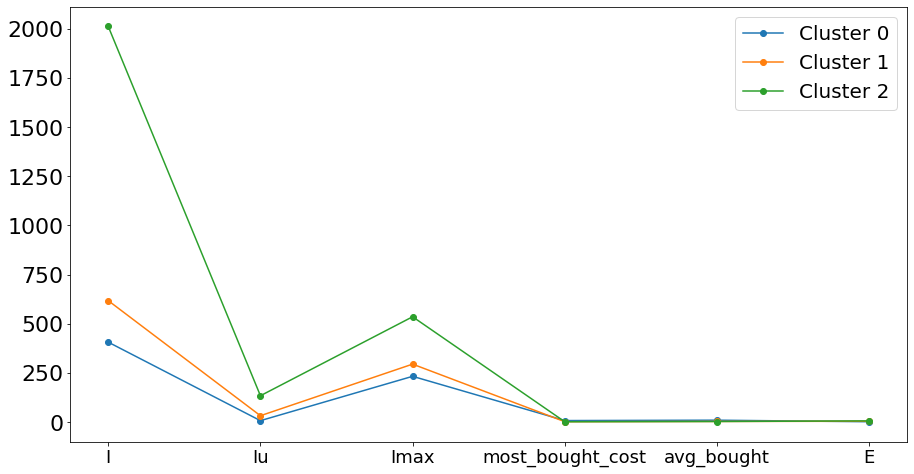

In [196]:
plt.figure(figsize=(15, 8))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(CICopyClustering.columns)), CICopyClustering.columns, fontsize=18)
plt.legend(fontsize=20)
plt.show()

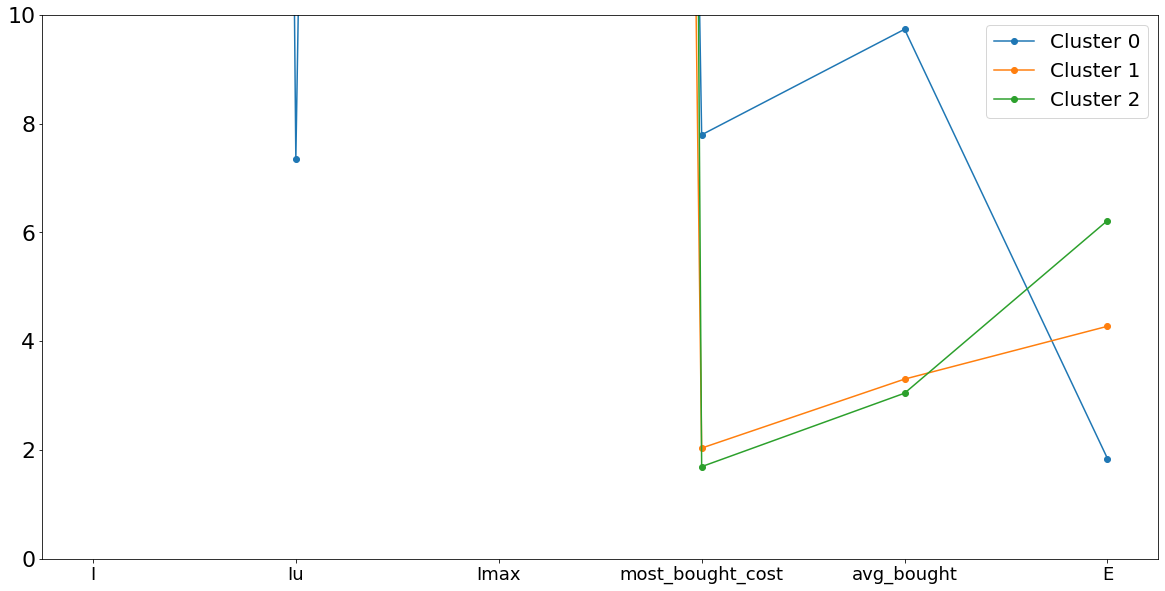

In [199]:
plt.figure(figsize=(20, 10))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(CICopyClustering.columns)), CICopyClustering.columns, fontsize=18)
plt.legend(fontsize=20)
plt.ylim(-0,10)
plt.show()

0= min #item totali / min #item distinti / min #item max in una sessione/ max costo prod piu acqui/ max costo prod medio/min E

1= mid #item totali/ mid #item distinti/ mid #item max in una sessione/ mid costo prod piu acqui / mid costo prod medio/ mid E

2= max #item totali / max #item distinti / max #item max in una sessione/ min costo prod piu acqui/ min costo prod medio/ max E

Cluster 0 --> customers che acquistano sempre gli stessi prodotti, sessioni piccole di prodotti costosi 

Cluster 1 --> customers STANDARD, spese con prodotti variegati ma costo basso

Cluster 2 --> customers che acquistano tantissimi prodotti, molto variegati, in sessioni grandi, di prodotti poco costosi. 

## Hierarchical clustering

Si sperimentano varie invocazioni dell'oggetto `AgglomerativeClustering` e come i clusters generati cambiano al variare delle metriche adottate.

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

X = scaler.fit_transform(customer_indicators[["I", "Iu", "spending", "Imax", "returned_items", "returning", "baskets", "E", "hour", "month"]].values)

X

array([[ 0.38253107,  0.48905563,  0.2724529 , ...,  0.93361624,
         0.65463635,  0.04296654],
       [-0.26702164, -0.45919538, -0.0220489 , ..., -0.11600832,
         2.81876845,  1.52643211],
       [-0.08635135,  0.13785155, -0.02670066, ...,  0.80793987,
        -1.50949576,  1.22973899],
       ...,
       [-0.34445176, -0.57626341, -0.21182204, ..., -1.04223262,
         0.22180993, -0.55041969],
       [ 2.85169168,  2.36214405,  0.01283526, ...,  1.67911004,
         0.65463635, -0.25372657],
       [-0.09925637, -0.02604369, -0.01735611, ...,  0.60060061,
        -1.07666934,  1.52643211]])

In [5]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=5, linkage="ward")
complete = AgglomerativeClustering(n_clusters=5, linkage="complete")
average = AgglomerativeClustering(n_clusters=5, linkage="average")
single = AgglomerativeClustering(n_clusters=5, linkage="single")

ward.fit_predict(X)
complete.fit_predict(X)
average.fit_predict(X)
single.fit_predict(X)

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

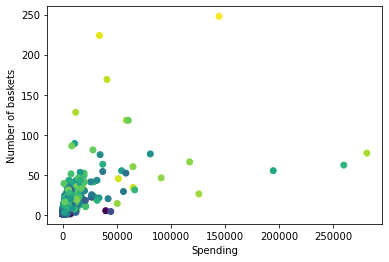

In [7]:
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = customer_indicators["E"]
)

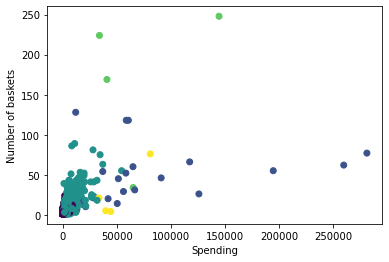

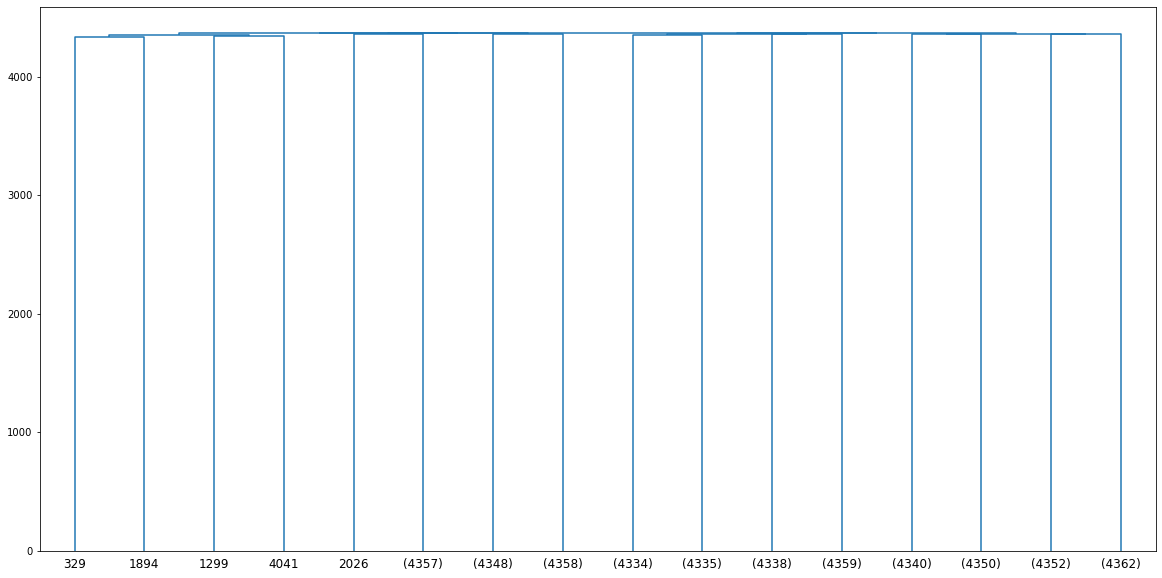

In [10]:
# Ward
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = ward.labels_
)
plt.figure(figsize=(20, 10))
plot_dendrogram(ward, truncate_mode='level', p=3)

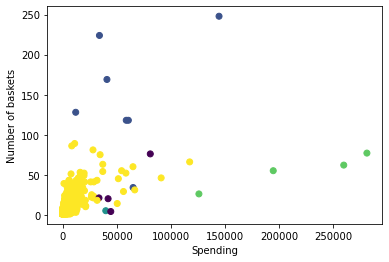

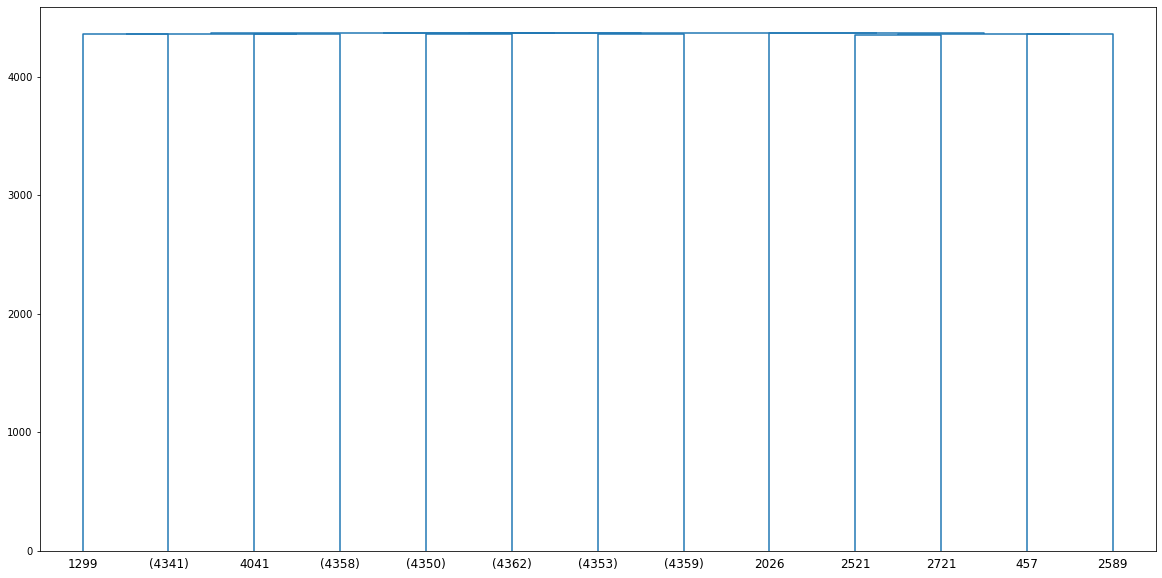

In [11]:
# Complete
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = complete.labels_
)
plt.figure(figsize=(20, 10))
plot_dendrogram(complete, truncate_mode='level', p=3)

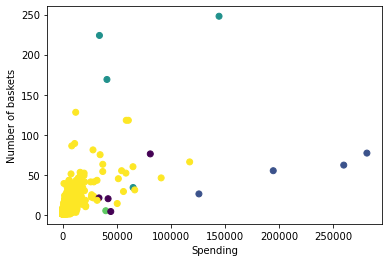

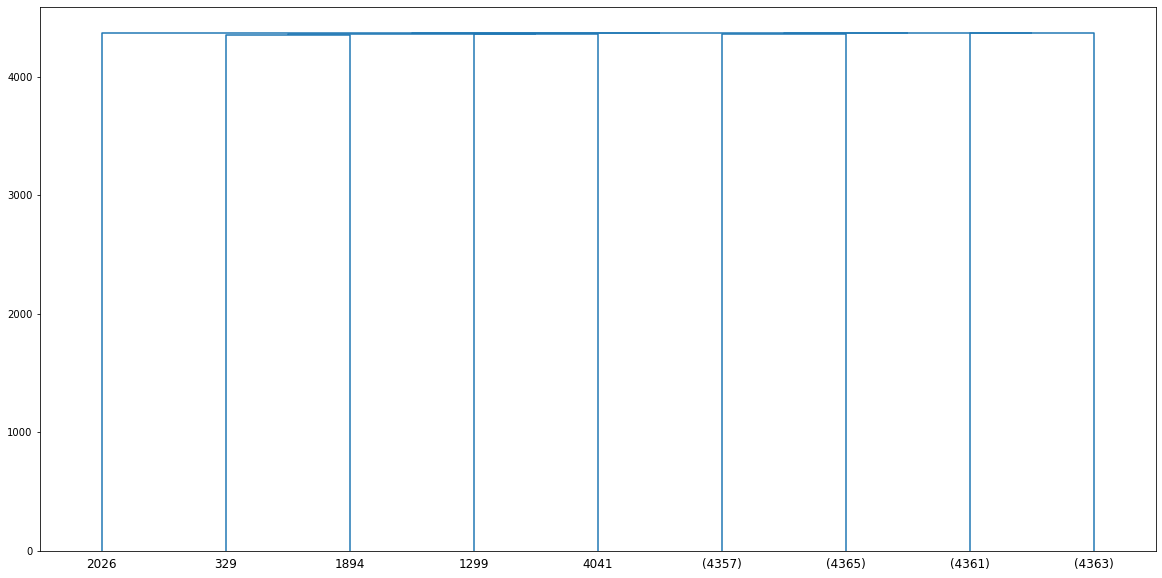

In [13]:
# Average
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = average.labels_
)
plt.figure(figsize=(20, 10))
plot_dendrogram(average, truncate_mode='level', p=3)

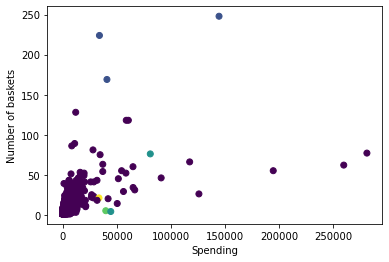

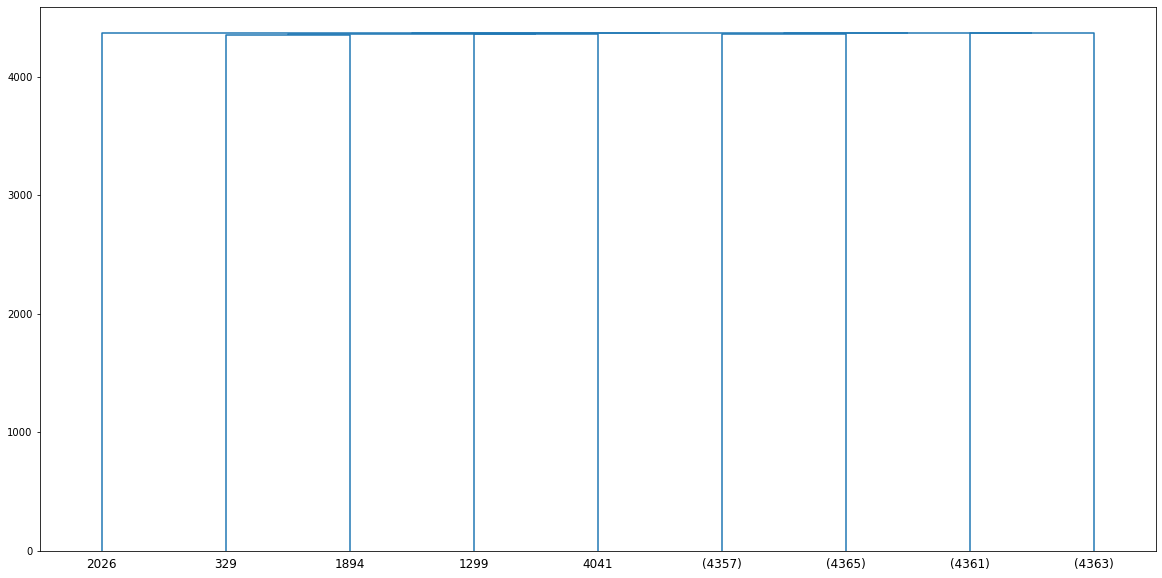

In [14]:
# Single
plt.xlabel("Spending")
plt.ylabel("Number of baskets")
plt.scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = single.labels_
)
plt.figure(figsize=(20, 10))
plot_dendrogram(average, truncate_mode='level', p=3)

## Principal Component Analysis

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
Y = pca.fit_transform(X)
plt.scatter(x = Y[:, 0], y = Y[:, 1], c=Y[:, 2])

NameError: name 'X' is not defined

In [ ]:
customer_indicators.sort_values(by=["hour", "month"])